In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

In [2]:
bullying = pd.read_csv("bullying.csv")

In [3]:
bullying.head()

,record,bullied_in_school,bullied_not_school,cyber_bullied,custom_age,sex,physically_attacked,physical_fighting,felt_lonely,close_friends,missed_school,other_students_kind_and_helpful,parents_understand_problems,most_of_the_time_or_always_felt_lonely,missed_classes,were_underweight,were_overweight,were_obese
0,1,Yes,Yes,NaN,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,NaN,NaN,NaN
1,2,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,NaN,NaN,NaN
2,3,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
3,4,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,NaN,No,No,No,No,No
4,5,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,NaN,NaN,NaN


###  Cleaning Data and Handling Null Values

In [4]:
bullying.isnull().sum()/bullying.shape[0] * 100

record                                     0.000000
bullied_in_school                          2.174409
bullied_not_school                         0.858181
cyber_bullied                              1.002088
custom_age                                 0.189537
sex                                        0.940664
physically_attacked                        0.421193
physical_fighting                          0.470332
felt_lonely                                0.642319
close_friends                              1.888349
missed_school                              3.271266
other_students_kind_and_helpful            2.736000
parents_understand_problems                4.164546
most_of_the_time_or_always_felt_lonely     0.642319
missed_classes                             3.271266
were_underweight                          36.729787
were_overweight                           36.729787
were_obese                                36.729787
dtype: float64

The columns with more than 5% of null values are going t be dropped. This includes the `were_obese`, `were_underweight`, `were_overweight` columns. From the EDA done which can be found <a href="https://github.com/yickysan/MLops/blob/main/notebook/Exploratory%20data%20analysis.ipynb">here</a> , these columns are not indicative of bullying. For the rest of the dataset, the null entries will be dropped. 

In [5]:
bullying.drop(
    ["were_obese", "were_underweight", "were_overweight"],
    axis=1, inplace=True
)
bullying.dropna(inplace=True)

In [6]:
bullying.isnull().sum()

record                                    0
bullied_in_school                         0
bullied_not_school                        0
cyber_bullied                             0
custom_age                                0
sex                                       0
physically_attacked                       0
physical_fighting                         0
felt_lonely                               0
close_friends                             0
missed_school                             0
other_students_kind_and_helpful           0
parents_understand_problems               0
most_of_the_time_or_always_felt_lonely    0
missed_classes                            0
dtype: int64

In [7]:
bullying.drop(
    ["record", "most_of_the_time_or_always_felt_lonely", "missed_classes"],
    axis=1, inplace=True
)
bullying["custom_age"] = bullying["custom_age"].str.extract("(\d+)").astype(int)
bullying["close_friends"] = bullying["close_friends"].str.extract("(\d+)").astype(int)
bullying["missed_school"] = bullying["missed_school"].str.extract("(\d+)").astype(int)

In [8]:
bullying.shape

(50754, 12)

## Creating Features and Target Variable

In [9]:
y = bullying["bullied_in_school"].astype("category").cat.codes
X = bullying.copy().drop("bullied_in_school", axis=1)
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].astype("category").cat.codes

In [10]:
y.value_counts(normalize=True)

0    0.789731
1    0.210269
dtype: float64

In [11]:
kbest = SelectKBest(chi2, k = "all")
X = kbest.fit_transform(X, y)

In [12]:
kbest.get_feature_names_out()

array(['bullied_not_school', 'cyber_bullied', 'custom_age', 'sex',
       'physically_attacked', 'physical_fighting', 'felt_lonely',
       'close_friends', 'missed_school',
       'other_students_kind_and_helpful', 'parents_understand_problems'],
      dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Evaluating Models

In [14]:
scale_pos_weight = y.value_counts().values[0]/y.value_counts().values[1]

In [15]:
models = {
    "logreg" : LogisticRegression(class_weight="balanced"),
    "randomforest" : RandomForestClassifier(class_weight="balanced", random_state=1),
    "adaboost" : AdaBoostClassifier(),
    "xgboost" : XGBClassifier(scale_pos_weight = scale_pos_weight),
    "svm" : SVC()
}

In [16]:
model_performance = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models.items():
    model_dict = {}
    model_name = k
    model = v
    model.fit(X_train, y_train) # fit the model with training data
    pred = model.predict(X_test)
    model_dict["auc_score"] = roc_auc_score(y_test, pred)
    model_dict["precision_score"] = precision_score(y_test, pred)
    model_dict["recall_score"] = recall_score(y_test, pred)
    model_dict["confusion_matrix"] = confusion_matrix(y_test, pred)
    model_performance[model_name] = model_dict

In [17]:
for key in model_performance.keys():
    print(key, ":", round(model_performance[key]["auc_score"], 3), "\n", 
            model_performance[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.709 
 [[6257 1712]
 [ 799 1383]]
---------------------------
randomforest : 0.622 
 [[7015  954]
 [1388  794]]
---------------------------
adaboost : 0.624 
 [[7580  389]
 [1535  647]]
---------------------------
xgboost : 0.702 
 [[6156 1813]
 [ 805 1377]]
---------------------------
svm : 0.514 
 [[7949   20]
 [2116   66]]
---------------------------


The xgboost and logistic regresion models performed best. Some hyperparameter tuning will be performed to see if the model performance can be improved.

## Hyperparameter Optimization.

### XGB Hyperparameter Optimization

In [18]:
learning_rate = [i/100 for i in range(1, 11)]
gamma = [i/10 for i in range(5)]
max_depth = range(3, 10, 2)
min_child_weight = range(1, 8, 2)
reg_alpha =[1e-5, 1e-2, 0.1, 1, 100]
subsample =[i/100 for i in range(75, 90, 5)]
colsample_bytree = [i/100 for i in range(75, 90, 5)]
scale_pos_weights = [1, 2, 3, 4, scale_pos_weight]

xgb_model = models["xgboost"]



In [19]:
%%time
xgb_param = {"n_estimators" : range(100, 550, 50)}
xgb_gridsearch = GridSearchCV(xgb_model, xgb_param, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch.fit(X, y)

print(xgb_gridsearch.best_score_)
print(xgb_gridsearch.best_params_)

0.7579010292094389
{'n_estimators': 100}
CPU times: total: 15.8 s
Wall time: 13min 54s


In [21]:
%%time
xgb_model2 = xgb_gridsearch.best_estimator_
xgb_param2 = {"max_depth" : max_depth,
              "min_child_weight" : min_child_weight
             }
xgb_gridsearch2 = GridSearchCV(xgb_model2, xgb_param2, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch2.fit(X, y)

print(xgb_gridsearch2.best_score_)
print(xgb_gridsearch2.best_params_)

0.7755177408726329
{'max_depth': 3, 'min_child_weight': 7}
CPU times: total: 8.98 s
Wall time: 8min 42s


In [22]:
%%time
xgb_model3 = xgb_gridsearch2.best_estimator_
xgb_param3 = {"learning_rate" : learning_rate,
              "gamma" : gamma }
xgb_gridsearch3 = GridSearchCV(xgb_model3, xgb_param3, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch3.fit(X, y)

print(xgb_gridsearch3.best_score_)
print(xgb_gridsearch3.best_params_)

0.7769757808446022
{'gamma': 0.0, 'learning_rate': 0.08}
CPU times: total: 12.2 s
Wall time: 12min 36s


In [23]:
%%time
xgb_model4 = xgb_gridsearch3.best_estimator_
xgb_param4 = {"reg_alpha" : reg_alpha,
              "subsample" : subsample,}
xgb_gridsearch4 = GridSearchCV(xgb_model4, xgb_param4, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch4.fit(X, y)

print(xgb_gridsearch4.best_score_)
print(xgb_gridsearch4.best_params_)

0.7772153927372416
{'reg_alpha': 1, 'subsample': 0.75}
CPU times: total: 12.4 s
Wall time: 5min 11s


In [24]:
%%time
xgb_model5 = xgb_gridsearch4.best_estimator_
xgb_param5 = {"colsample_bytree" : colsample_bytree,
             "scale_pos_weight" : scale_pos_weights}
xgb_gridsearch5 = GridSearchCV(xgb_model5, xgb_param5, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch5.fit(X, y)

print(xgb_gridsearch5.best_score_)
print(xgb_gridsearch5.best_params_)

0.7771622426214663
{'colsample_bytree': 0.75, 'scale_pos_weight': 3.7558095952023987}
CPU times: total: 11.2 s
Wall time: 3min 53s


In [39]:
xgb_gridsearch4.best_estimator_.fit(X_train, y_train)
xgb_pred = xgb_gridsearch4.best_estimator_.predict(X_test)

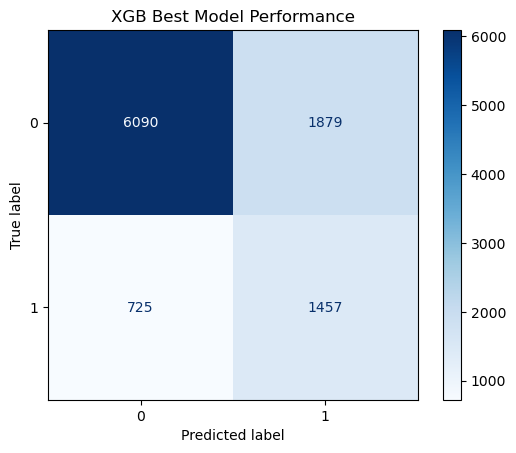

auc_score: 0.7160


In [41]:
xgb_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_pred))
xgb_model_plot.plot(cmap=plt.cm.Blues)
xgb_model_plot.ax_.set_title("XGB Best Model Performance")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, xgb_pred)
)

After performing hyperparameter tuning on the xgboost model, there is a slight impovement and the model can better predict the minority class but the difference in model performance isn't really significant.

### LogisticRegression Hyperparameter Tuning

In [29]:
lgr_clf = models["logreg"]

fit_intercept = [True, False]
penalty = ["l1", "l2", "elasticnet"]
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
class_weights = [{0:1, 1:99}, {0:10, 1:90}, {0:5, 1:95},
                {0:15, 1:85}, {0:20, 1:80}, {0:25,1:75},
                {0:19, 1:71}, {0:21, 1:69}, {0:11, 1:79}]

In [30]:
%%time
lgr_param = {"penalty" : penalty,
            "solver" : solver,
            "fit_intercept" : fit_intercept}
lgr_gridsearch = GridSearchCV(lgr_clf, lgr_param, cv=10, scoring="roc_auc", n_jobs=-1)
lgr_gridsearch.fit(X, y)

print(lgr_gridsearch.best_score_)
print(lgr_gridsearch.best_params_)

0.7606220060874347
{'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: total: 2.77 s
Wall time: 1min 21s


In [32]:
%%time
lgr_clf2 = lgr_gridsearch.best_estimator_
lgr_param2 = {"class_weight" : class_weights}
lgr_gridsearch2 = GridSearchCV(lgr_clf2, lgr_param2, cv=10, scoring="roc_auc", n_jobs=-1)
lgr_gridsearch2.fit(X, y)

print(lgr_gridsearch2.best_score_)
print(lgr_gridsearch2.best_params_)

0.7608389252355596
{'class_weight': {0: 1, 1: 99}}
CPU times: total: 1.89 s
Wall time: 17.2 s


In [34]:
lgr_gridsearch2.best_estimator_.fit(X_train, y_train)
lgr_pred = lgr_gridsearch2.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, lgr_pred))
print(confusion_matrix(y_test, lgr_pred))

0.5
[[   0 7969]
 [   0 2182]]


Despite the second logistic regression model performing better with the class weights in the grid_search. It doesn't do a good job at predicting the test data.

In [35]:
lgr_gridsearch.best_estimator_.fit(X_train, y_train)
lgr_pred = lgr_gridsearch.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, lgr_pred))
print(confusion_matrix(y_test, lgr_pred))

0.7092029621198275
[[6256 1713]
 [ 800 1382]]


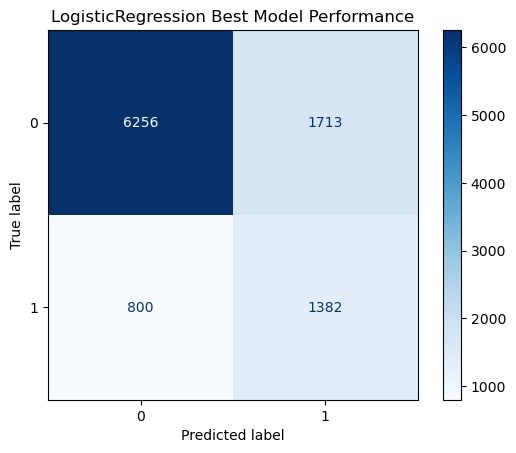

auc_score: 0.7092


In [42]:
lgr_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, lgr_pred))
lgr_model_plot.plot(cmap=plt.cm.Blues)
lgr_model_plot.ax_.set_title("LogisticRegression Best Model Performance")
plt.show()

print(
    "auc_score: %.4f" %roc_auc_score(y_test, lgr_pred)
)

The logistic regression model performed slightly worse than the xgboost one and didn't show any improvement from the original logistic regression model. Overall, both the xgboost and logistic regression models aren't too great. Next a custom model combining both xgboost and logistic regression will be used to see if there will be any improvement.

## Creating Custom Model.

In [43]:
class CustomBagger:
    """
    Function to make predictions with two models using bagging technique.
    
    This function utilises one `sklearn.linear_model.LogisticRegression` model and an `xgboost.XGBClassifier` model to make
    predictions on the dataset. Predictions are made by taking the average probability prediction of both models.
    A value of 1 will be predicted if the probability is greater than 0.5, otherwise it will be 0.
    
    Attributes:
    ----------
    model_1 : 
        either an `xgboost.XGBClassifier` model or an `sklearn.linear_model.LogisticRegression` model
        
    model_2 :
        either an `xgboost.XGBClassifier` model or an `sklearn.linear_model.LogisticRegression` model
        
    Methods:
    -------
    fit(X_train, y_train)
        This method splits the dataset equally and fits the models with each half of the split dataset
        
    predict(y_test)
        This method returns the average prediction of both models
    """
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        
    def fit(self, X_train, y_train):
        size = X_train.shape[0] // 2 # splitting the train data into equal parts to fit in the two models
        X_train_1, y_train_1 = X_train[:20301], y_train[:20301]
        X_train_2, y_train_2 = X_train[20301:], y_train[20301:]
        
        self.model_1 = self.model_1.fit(X_train_1, y_train_1)
        self.model_2 = self.model_2.fit(X_train_2, y_train_2)
        
    def predict(self, y_test):
        model_1_pred = pd.Series(self.model_1.predict_proba(y_test)[:, 1], name="model_1_pred")
        model_2_pred = pd.Series(self.model_2.predict_proba(y_test)[:, 1], name="model_2_pred")
        pred_table = pd.concat([model_1_pred, model_2_pred], axis=1) # creates a pandas data frame with predicttions of both model
        predictions = pred_table.mean(axis=1) # takes the average of both predictions
        predictions = predictions.apply(lambda x: 1 if x > 0.5 else 0).values # predicts 1 for probability greater than 0.55
        
        return predictions
        
        

In [44]:
model_1 = xgb_gridsearch4.best_estimator_
model_2 = lgr_gridsearch.best_estimator_

custom_bagger = CustomBagger(model_1, model_2)

custom_bagger.fit(X_train, y_train)

preds = custom_bagger.predict(X_test)

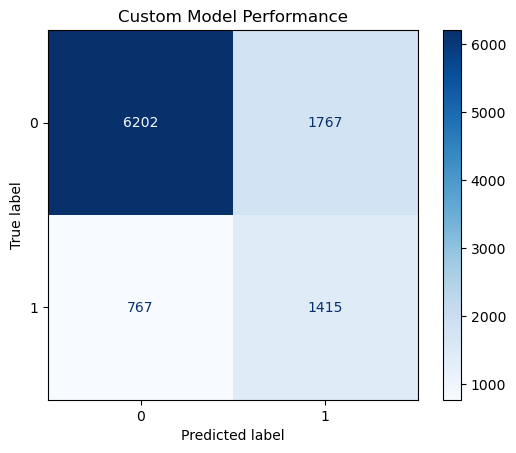

auc_score: 0.7134


In [47]:
custom_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
custom_model_plot.plot(cmap=plt.cm.Blues)
custom_model_plot.ax_.set_title("Custom Model Performance")
plt.show()

print(
    "auc_score: %.4f" %roc_auc_score(y_test, preds)
)

The custom  model sits in between the logistic regression model and the xgboost model. Overall there isn't a significant difference between all three models.

## Predicting Using Synthetic Minority Over Sampling (SMOTE) and Random Under Sampling

A combinantion of both smote over sampling and a random undersampling wil be performed on the train dataset before making predictions on the test dataset.

### Over Sampling

In [55]:
over_sampler = SMOTE(sampling_strategy=0.8)
#under_sampler = RandomUnderSampler(sampling_strategy=0.8)
#pipe = Pipeline([("over", over_sampler), ("under", under_sampler)])
X_s, y_s = over_sampler.fit_resample(X_train, y_train)

In [56]:
y_s.value_counts()

0    32113
1    25690
dtype: int64

In [112]:
# the s in the variale names is to indicate they are from the resampled data
models_s = {
    "logreg" : LogisticRegression(),
    "randomforest" : RandomForestClassifier(random_state=1),
    "adaboost" : AdaBoostClassifier(random_state=1),
    "xgboost" : XGBClassifier(random_state=1),
    "svm" : SVC(random_state=1)
}

In [113]:
model_performance_s = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_s = {}
    model_name_s = k
    model_s = v
    model_s.fit(X_s, y_s) # fit the model with training data
    pred_s = model_s.predict(X_test)
    model_dict_s["auc_score"] = roc_auc_score(y_test, pred_s)
    model_dict_s["precision_score"] = precision_score(y_test, pred_s)
    model_dict_s["recall_score"] = recall_score(y_test, pred_s)
    model_dict_s["confusion_matrix"] = confusion_matrix(y_test, pred_s)
    model_performance_s[model_name_s] = model_dict_s

In [114]:
for key in model_performance_s.keys():
    print(key, ": %.4f" %model_performance_s[key]["auc_score"], "\n", 
            model_performance_s[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.6960 
 [[6554 1415]
 [ 939 1243]]
---------------------------
randomforest : 0.6515 
 [[6428 1541]
 [1099 1083]]
---------------------------
adaboost : 0.6995 
 [[6481 1488]
 [ 904 1278]]
---------------------------
xgboost : 0.6831 
 [[6483 1486]
 [ 976 1206]]
---------------------------
svm : 0.6915 
 [[6795 1174]
 [1025 1157]]
---------------------------


The over sampled dataset didn't show any improvement. Infact, it performed worse than the models wihtout oversampled data.

### Under Sampling.

In [115]:
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
X_us, y_us = under_sampler.fit_resample(X_train, y_train)
y_us.value_counts()

0    10612
1     8490
dtype: int64

In [116]:
model_performance_us = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_us = {}
    model_name_us = k
    model_us = v
    model_us.fit(X_us, y_us) # fit the model with training data
    pred_us = model_us.predict(X_test)
    model_dict_us["auc_score"] = roc_auc_score(y_test, pred_us)
    model_dict_us["precision_score"] = precision_score(y_test, pred_us)
    model_dict_us["recall_score"] = recall_score(y_test, pred_us)
    model_dict_us["confusion_matrix"] = confusion_matrix(y_test, pred_us)
    model_performance_us[model_name_us] = model_dict_us

In [117]:
for key in model_performance_us.keys():
    print(key, ": %.4f" %model_performance_us[key]["auc_score"], "\n", 
            model_performance_us[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.7025 
 [[6565 1404]
 [ 914 1268]]
---------------------------
randomforest : 0.6894 
 [[5936 2033]
 [ 799 1383]]
---------------------------
adaboost : 0.7050 
 [[6544 1425]
 [ 897 1285]]
---------------------------
xgboost : 0.7048 
 [[6302 1667]
 [ 832 1350]]
---------------------------
svm : 0.6854 
 [[6889 1080]
 [1077 1105]]
---------------------------


With the exception of the adaboost and SVM models, the under sampled dataset produced a much worse result than than the regular dataset. Finally a combination of both over sampling and under sampling will be performed to see how well the models will improve.

In [121]:
over_sampler = SMOTE(sampling_strategy=0.6)
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
pipe = Pipeline([("over", over_sampler), ("under", under_sampler)])
X_ds, y_ds = pipe.fit_resample(X_train, y_train)
y_ds.value_counts()

0    24083
1    19267
dtype: int64

In [122]:
model_performance_ds = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_ds = {}
    model_name_ds = k
    model_ds = v
    model_ds.fit(X_ds, y_ds) # fit the model with training data
    pred_ds = model_ds.predict(X_test)
    model_dict_ds["auc_score"] = roc_auc_score(y_test, pred_ds)
    model_dict_ds["precision_score"] = precision_score(y_test, pred_ds)
    model_dict_ds["recall_score"] = recall_score(y_test, pred_ds)
    model_dict_ds["confusion_matrix"] = confusion_matrix(y_test, pred_ds)
    model_performance_ds[model_name_ds] = model_dict_ds

In [123]:
for key in model_performance_ds.keys():
    print(key, ": %.4f" %model_performance_ds[key]["auc_score"], "\n", 
            model_performance_ds[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.6981 
 [[6572 1397]
 [ 935 1247]]
---------------------------
randomforest : 0.6568 
 [[6309 1660]
 [1043 1139]]
---------------------------
adaboost : 0.6993 
 [[6503 1466]
 [ 911 1271]]
---------------------------
xgboost : 0.6847 
 [[6413 1556]
 [ 950 1232]]
---------------------------
svm : 0.6914 
 [[6809 1160]
 [1029 1153]]
---------------------------


## Conclusion
Whether under sampling, over sampling or a combination of both, there wasn't a significant improvement of the models over the ones using the data with their actual sampling. The model that is best for the data is the tuned xgboost model, it has the least false positives and does best in predicting the minority class.